In [2]:
#!/usr/bin/python3

import numpy as np

class Segment:
    '''SEGMENT - Representation of a segment of a tree

    Some terminology:

    - A NODE is a node of the neurite tree with an ID that matches the sbemdb.
    - An EDGE is a connection between adjacent nodes, corresponding to a 
      "nodecon" in the sbemdb, but without its own ID.
    - The FANOUT of a NODE is the number of EDGES that meet there.
    - A SEGMENT is a linear chain of NODES connected by EDGES such that
      all the internal NODES have FANOUT equal to two, whereas the first
      and last NODE have FANOUT not equal to two.

    Segments are organized in a TREE. The ROOT of the tree typically is
      the segment that contains the soma. 
    - CHILD segments by definition connect to the PARENT segment with their
      first node attached to the parent's last node.
    - A TERMINAL SEGMENT is a SEGMENT without children.
    '''
    def __init__(self, sid=None, parent=None, nodes=[]):
        '''Construct an empty segment'''
        self.sid = sid
        self.parent = parent
        self.nodes = nodes
        self.children = []
        self.pathlen = None
        self.hassyn = None
        self.depth = 0 # Number of junctions from root
        self.neighbor_dist = None
        
    def is_terminal(self):
        '''IS_TERMINAL - Returns true if the segment has no children'''
        return len(self.children)==0

    def edge_count(self):
        '''EDGE_COUNT() returns the number of EDGES in the chain'''
        N = len(self.nodes)
        if N==0:
            return 0
        else:
            return N-1
    
    
    def __repr__(self):
        r = f'Segment({self.sid})'
        if len(self.nodes)==1:
            r += f' with 1 node: [{self.nodes[0]}]'
        else:
            r += f' with {len(self.nodes)} nodes'
            if len(self.nodes)>=2:
                r += f': [{self.nodes[0]} ... {self.nodes[-1]}]'
        if len(self.children)==1:
            r += f' and 1 child'
        elif len(self.children)==0:
            r += f' without children'
        else:
            r += f' and {len(self.children)} children'
        return r

class Tree(dict):
    '''TREE - Representation of a neuritic tree in terms of segments
    
    A TREE is a dict mapping "segment IDs" to segments.
    The root of the tree has ID zero. 

    - DROP: Remove a terminal segment from the tree and remodel as needed.
'''
    
    def __init__(self, rootnid, db):
        '''Tree(rootnid, db) construct a tree starting from the given node.
        DB must be an SBEMDB'''
        self.seen = set()
        tid = db.fetch(f'select tid from nodes where nid=={rootnid}')[0][0]
        rows = db.fetch(f'''select nid1, nid2 from nodecons 
        inner join nodes on nid2==nid
        where tid=={tid}''')
        self.cons = {}
        for row in rows:
            if row[0] not in self.cons:
                self.cons[row[0]] = []
            self.cons[row[0]].append(row[1])
        self._explore([rootnid], None)
        del self.cons
        del self.seen
        self._typify(db, tid)
        self._establish_depths()
        self._establish_lengths(db, rootnid)
        self._establish_neighbor_dists(db)

    def _idgen(self):
        return len(self)

    def _explore(self, chain, parent):
        nid = chain[-1]
        for n in chain:
            self.seen.add(n)
        while True:
            nids = [n for n in self.cons[nid] if n not in self.seen]
            for n in nids:
                self.seen.add(n)
            if len(nids)==0:
                myid = self._idgen()
                s = Segment(myid, parent, chain)
                self[myid] = s
                return myid
            elif len(nids)==1:
                chain.append(nids[0])
                nid = nids[0]
            else:
                myid = self._idgen()
                s = Segment(myid, parent, chain)
                self[myid] = s
                for n in nids:
                    self[myid].children.append(self._explore([nid, n], myid))
                return myid

    def _establish_depths(self):
        sids = list(self.keys())
        sids.sort()
        for sid in sids:
            pid = self[sid].parent
            if pid is None:
                self[sid].depth = 0
            else:
                par = self[pid]
                self[sid].depth = self[pid].depth + 1

    def _establish_lengths(self, db, rootnid):
        dd = db.distanceAlongTree(rootnid)
        for sid, seg in self.items():
            self[sid].pathlen = dd[seg.nodes[-1]] - dd[seg.nodes[0]]
                   
    def _typify(self, db, tid):
        rows = db.fetch(f'select nid, typ from nodes where tid=={tid}')
        typs = { row[0]: row[1] for row in rows }
        for sid, seg in self.items():
            hassyn = False
            for n in seg.nodes:
                if typs[n]==6:
                    hassyn = True
                    break
            self[sid].hassyn = hassyn

    def is_terminal(self, sid):
        '''IS_TERMINAL(id) returns true if the segment has no children'''
        return len(self[sid].children)==0

    def siblings(self, sid):
        '''SIBLINGS(sid) returns a list of siblings of a given segment.'''
        pid = self[sid].parent
        if pid is None:
            return []
        return [ s for s in self[pid].children if s != sid ]
            
    def drop(self, sid):
        '''DROP(id) removes the named segment from the tree.
        Only terminal segments can be removed.
        The tree is remodeled such that if the removed segment had 
        precisely one sibling, that sibling is concatenated to its 
        parent and removed from the tree.'''
        if not self.is_terminal(sid):
            raise ValueError(f'Cannot drop internal segment {sid}')
        pid = self[sid].parent
        sibs = self.siblings(sid)
        self[pid].children.remove(sid)
        del self[sid]

        def reestablish_depth(tree, sid, d):
            for s in tree[sid].children:
                tree[s].depth = d + 1
                reestablish_depth(tree, s, d + 1)

        if len(sibs)==1:
            sib = sibs[0]
            self[pid].nodes += self[sib].nodes[1:]
            if self[sib].hassyn:
                self[pid].hassyn = True
            self[pid].children = self[sib].children
            self[pid].pathlen += self[sib].pathlen
            for c in self[pid].children:
                self[c].parent = pid
            del self[sib]
            reestablish_depth(self, pid, self[pid].depth)

    def _neighbor_dist(self, sid, db):
        '''NEIGHBOR_DIST - Distance between terminal node and neighboring edges
        NEIGHBOR_DIST(seg_id, db) returns the distance (in microns) between
        the terminal node of the given chain and the edges in the chain's
        parent or siblings that are adjacent to the given chains base
        node. Second argument must be a SBEMDB to use for measurements.'''
        nid_term = self[sid].nodes[-1]
        nid_base = self[sid].nodes[0]
        par_id = self[sid].parent
        if par_id is None:
            return None
        sib_ids = self.siblings(sid)
        nid_neighbors = [ self[par_id].nodes[-2] ]
        for s in sib_ids:
            nid_neighbors.append(self[s].nodes[1])
        dd = [ db.nodeToEdgeDistance(nid_term, nid_base, n_nei)
               for n_nei in nid_neighbors ]
        return np.min(dd)

    def _establish_neighbor_dists(self, db):
        for s in self.keys():
            self[s].neighbor_dist = self._neighbor_dist(s, db)

    def prune_stubs(self, db, max_dist_um, max_edge_cnt=1):
        cands = set()
        for sid, seg in self.items():
            if (seg.is_terminal()
                and seg.neighbor_dist <= max_dist_um
                and seg.edge_count() <= max_edge_cnt):
                cands.add(sid)
        # CANDS are terminal segments we are willing to prune
        # Careful: If _all_ siblings at some junction are prunable,
        # we should keep the longest one
        keep = set()
        for sid in cands:
            sibs = self.siblings(sid)
            alldel = True
            for s in sibs:
                if s not in cands:
                    alldel = False
                    break
            if alldel:
                sibs.append(sid)
                lens = [ self[s].pathlen for s in sibs ]
                keep.add(sibs[np.argmax(lens)])
        for s in keep:
            cands.remove(s)
        cands = list(cands)
        cands.sort()
        for s in cands[-1::-1]:
            if s in self:
                self.drop(s)
        self._establish_neighbor_dists(db)

    def plot(self, db):
        import matplotlib.pyplot as plt
        def xyz(nodes):
            xx=[]
            yy=[]
            zz=[]
            for n in nodes:
                x,y,z = db.onenodexyz(n)
                xx.append(x)
                yy.append(y)
                zz.append(z)
            return xx,yy,zz
        plt.figure()
        for sid, seg in self.items():
            xx,yy,zz = xyz(seg.nodes)
            if seg.depth==0:
                c = 'r'
            elif seg.depth==1 and not seg.is_terminal():
                c = 'b'
            elif seg.is_terminal():
                c = 'k'
            else:
                c = 'y'
            plt.plot(xx,zz, c)
                    

    def save_csv(self, ofn):
        with open(ofn, 'w') as fd:
            fd.write('segment_id,branch_id,type,depth,is_synapse,'
                     + 'node_id,point_node_id\n')
            for sid, seg in self.items():
                if seg.depth==0:
                    typ = 'main'
                elif seg.depth==1 and not seg.is_terminal():
                    typ = 'root'
                elif seg.is_terminal():
                    typ = 'ts'
                else:
                    typ = 'is'
                for k in range(1, len(seg.nodes)):
                    fd.write(f'{sid},0,{typ},{seg.depth},{seg.hassyn},'
                             + f'{seg.nodes[k]},{seg.nodes[k-1]}\n')

In [3]:
from sbemdb import SBEMDB
db = SBEMDB()
tid = 444
nid = db.fetch(f'select nid from nodes where tid=={tid} and typ==1')[0][0]
tre = Tree(nid, db)

isterm = [ False, True ]
hassyns = [ False, True ]
isterml = ['Internal', 'Terminal']
hassynl = ['No syn', 'Has syn']
distcol = [ [[], []], [[], []] ]
lencol = [ [[], []], [[], []] ]
edgecnt = [ [[], []], [[], []] ]
for t in range(2):
    for s in range(2):
        for sid, seg in tre.items():
            if seg.is_terminal()==isterm[t] and seg.hassyn==hassyns[s]:
                # This is a chain we want to study now
                distcol[t][s].append(seg.neighbor_dist)
                lencol[t][s].append(seg.pathlen)
                edgecnt[t][s].append(seg.edge_count())

def jitter(x, dx=.8):
    return x + np.random.rand((len(x)))*dx - dx/2

import matplotlib.pyplot as plt
plt.interactive(True)
plt.close('all')

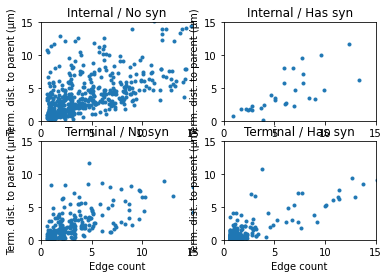

In [4]:
# Create scatter plots of terminal distance vs edge count
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        hh[t][s].plot(jitter(edgecnt[t][s]), distcol[t][s], '.')
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 15)
        hh[t][s].set_ylim(0, 15)            
        hh[t][s].set_xlabel('Edge count')
        hh[t][s].set_ylabel('Term. dist. to parent (μm)') 
  

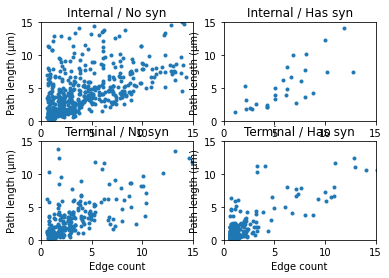

In [5]:
# Create scatter plots of path length vs edge count
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        hh[t][s].plot(jitter(edgecnt[t][s]), lencol[t][s], '.')
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 15)
        hh[t][s].set_ylim(0, 15)            
        hh[t][s].set_xlabel('Edge count')
        hh[t][s].set_ylabel('Path length (μm)')            

In [6]:
# Create histograms of terminal distance for edgecount=1 and all
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        dx = .05
        y,x = np.histogram([distcol[t][s][k]
                            for k in range(len(distcol[t][s]))
                            if distcol[t][s][k] is not None],
                           bins = np.arange(0, 5, dx))
        hh[t][s].bar((x[:-1]+ x[1:])/2, y, dx)
        y,x = np.histogram([distcol[t][s][k]
                            for k in range(len(distcol[t][s]))
                            if edgecnt[t][s][k]==1],
                           bins = np.arange(0, 5, dx))
        hh[t][s].bar((x[:-1]+ x[1:])/2, y, dx)
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 5)
        hh[t][s].set_ylim(0, 50)            
        hh[t][s].set_ylabel('Instance count')
        hh[t][s].set_xlabel('Term. dist. to parent (μm)')            

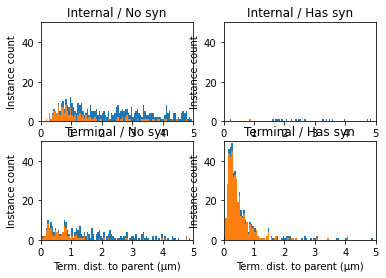

In [7]:
# I am going to say that edgecnt = 1 and dist <= 1.0 um means
# that this is a special case.

import copy
tr = copy.deepcopy(tre)
tr.prune_stubs(db, 1.0)

distcol = [ [[], []], [[], []] ]
lencol = [ [[], []], [[], []] ]
edgecnt = [ [[], []], [[], []] ]
for t in range(2):
    for s in range(2):
        for sid, seg in tr.items():
            if seg.is_terminal()==isterm[t] and seg.hassyn==hassyns[s]:
                # This is a chain we want to study now
                distcol[t][s].append(seg.neighbor_dist)
                lencol[t][s].append(seg.pathlen)
                edgecnt[t][s].append(seg.edge_count())

In [29]:
interest = []
for sid, seg in tr.items():
    if seg.is_terminal()==isterm[1] and seg.hassyn==hassyns[1] and seg.edge_count() == 1:
        interest.append(seg)
print(interest)
interested = [distcol[1][1][k] for k in range(len(distcol[1][1])) if edgecnt[1][1][k]==1]
print(len(interest))
print(len(interested))

31
[Segment(171) with 2 nodes: [15012 ... 27181] without children, Segment(174) with 2 nodes: [15006 ... 27178] without children, Segment(175) with 2 nodes: [15006 ... 27179] without children, Segment(179) with 2 nodes: [14997 ... 27177] without children, Segment(242) with 2 nodes: [6580 ... 26220] without children, Segment(308) with 2 nodes: [6746 ... 6747] without children, Segment(342) with 2 nodes: [7768 ... 27495] without children, Segment(376) with 2 nodes: [11248 ... 27493] without children, Segment(383) with 2 nodes: [11225 ... 27490] without children, Segment(388) with 2 nodes: [11220 ... 26206] without children, Segment(393) with 2 nodes: [6817 ... 26204] without children, Segment(394) with 2 nodes: [6817 ... 27486] without children, Segment(410) with 2 nodes: [6792 ... 14923] without children, Segment(411) with 2 nodes: [6773 ... 19044] without children, Segment(413) with 2 nodes: [6769 ... 23039] without children, Segment(421) with 2 nodes: [6759 ... 14920] without children

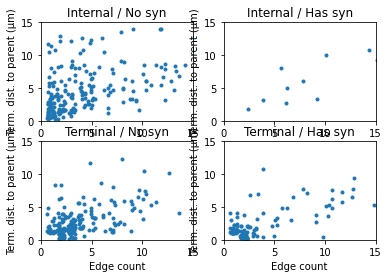

In [9]:
# Create scatter plots of term distance vs edge count
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        hh[t][s].plot(jitter(edgecnt[t][s]), distcol[t][s], '.')
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 15)
        hh[t][s].set_ylim(0, 15)            
        hh[t][s].set_xlabel('Edge count')
        hh[t][s].set_ylabel('Term. dist. to parent (μm)')            

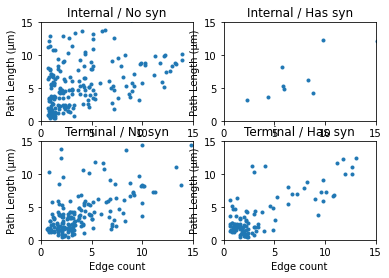

In [10]:
# Create scatter plots of path len vs edge count
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        hh[t][s].plot(jitter(edgecnt[t][s]), lencol[t][s], '.')
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 15)
        hh[t][s].set_ylim(0, 15)            
        hh[t][s].set_xlabel('Edge count')
        hh[t][s].set_ylabel('Path Length (μm)')            

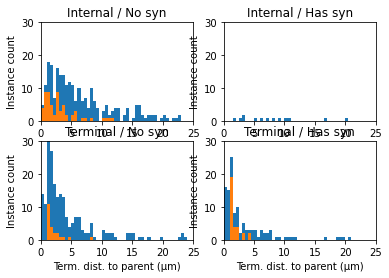

PermissionError: [Errno 13] Permission denied: 'segments_table_dw.csv'

In [11]:
# Create histograms of terminal distance for edgecount=1 and all
f,hh = plt.subplots(2,2)
for t in range(2):
    for s in range(2):
        dx = .5
        y,x = np.histogram([distcol[t][s][k]
                            for k in range(len(distcol[t][s]))
                            if distcol[t][s][k] is not None],
                           bins = np.arange(0, 25, dx))
        hh[t][s].bar((x[:-1]+ x[1:])/2, y, dx)
        y,x = np.histogram([distcol[t][s][k]
                            for k in range(len(distcol[t][s]))
                            if edgecnt[t][s][k]==1],
                           bins = np.arange(0, 25, dx))
        hh[t][s].bar((x[:-1]+ x[1:])/2, y, dx)
        hh[t][s].set_title(f'{isterml[t]} / {hassynl[s]}')
        hh[t][s].set_xlim(0, 25)
        hh[t][s].set_ylim(0, 30)            
        hh[t][s].set_ylabel('Instance count')
        hh[t][s].set_xlabel('Term. dist. to parent (μm)')            
  
plt.show()

tr.save_csv('segments_table_dw.csv')

tre.plot(db)
tr.plot(db)

In [40]:
flag = []
for sid, seg in tr.items():
    if seg.is_terminal() and seg.hassyn:
        if seg.edge_count() == 1 and seg.neighbor_dist > 1:
            print(seg.edge_count(), seg.neighbor_dist, seg.pathlen, seg.nodes[-1], '|')
            flag.append((db.onenodexyz(seg.nodes[-1])))

1 1.0263077356554287 2.534151560589521 27181 |
1 1.0514259957679095 2.3930882018270268 27178 |
1 1.4750412800402752 1.9927965685449749 27179 |
1 1.08168158600012 1.5477005484268034 27177 |
1 1.4119114613466586 2.420653395602244 26220 |
1 1.69712726438203 2.419278913965684 6747 |
1 1.4863595502021096 2.1653521484096245 27495 |
1 1.7252051785726041 1.9227344908689474 27493 |
1 1.3133767724429508 1.7023171532816832 27490 |
1 1.19623960899756 1.9911870404524734 26206 |
1 1.721979965048815 3.5738483193158572 26204 |
1 1.0551176526746864 1.4276621190038554 27486 |
1 1.49072884245635 1.5421708508515053 14923 |
1 2.149283218223549 2.469788864265354 19044 |
1 1.018752845766286 1.8877641560181928 23039 |
1 1.2040462049439886 1.2382811507052338 14920 |
1 1.5543973798676953 1.5543973798676802 25874 |
1 2.3846208725468783 4.618222606875918 25867 |
1 1.4106030632446842 3.68584883140511 25870 |
1 2.2783712029283274 2.309751357954383 6716 |
1 1.2714607220258516 1.27759750394398 26986 |
1 1.11201658149

In [41]:
flag

[(87.43455810546874, 418.6455625, 177.70000000000002),
 (84.81523681640624, 428.40088671875, 181.55),
 (85.10265478515625, 429.63060937499995, 180.25),
 (84.45850488281249, 431.70724609375, 181.70000000000002),
 (97.8731760147821, 394.02985684442984, 228.9),
 (108.0905315263804, 450.7680324070303, 271.40000000000003),
 (100.80538039206773, 479.01944132816317, 297.90000000000003),
 (93.34920185575606, 571.4370897789826, 291.85),
 (100.5955045480544, 530.8335713144196, 305.40000000000003),
 (101.97855078125, 522.71230859375, 309.5),
 (101.48099044857126, 507.63787506363167, 311.25),
 (102.8289453125, 510.25639843749997, 310.8),
 (102.71637563594065, 479.6300843495721, 296.7),
 (102.71878577445179, 472.73640644773906, 289.15000000000003),
 (103.4289072265625, 470.4779921875, 287.8),
 (107.30951171874999, 463.51967578125, 280.3),
 (107.99690429687499, 421.1632734375, 253.9),
 (105.04067578124999, 404.72536328125, 250.10000000000002),
 (105.57080628984484, 407.42455690149205, 252.25),
 (104